In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy import interpolate
from scipy.optimize import curve_fit

In [2]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [3]:
list(f.keys())

['DSV_00', 'U', 'Uk', 'eta', 'k', 't', 'x', 'y', 'z']

In [4]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')

In [5]:
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [83]:
kx_0 = np.arange(0.01, 0.35, 0.0005)
ky_0 = np.arange(0.01, 0.35, 0.0005)
# DWL = deep water limit
h = 100

w_0 = np.sqrt( 9.81 * np.sqrt( (kx_0)**2  + (ky_0)**2 ) * np.tanh(h*np.sqrt( (kx_0)**2  + (ky_0)**2 )))
# DWL formula

In [84]:
velocity = Uk[:,0]

In [85]:
k*velocity

array([0.00054946, 0.00060328, 0.00065939, 0.00071776, 0.00077836,
       0.00084117, 0.00090616, 0.00097331, 0.00104259, 0.00111399,
       0.00118747, 0.00126301, 0.0013406 , 0.0014202 , 0.0015018 ,
       0.00158538, 0.00167091, 0.00175838, 0.00184776, 0.00193904,
       0.0020322 , 0.00212721, 0.00222406, 0.00232274, 0.00242321,
       0.00252547, 0.0026295 , 0.00273528, 0.0028428 , 0.00295203,
       0.00306296, 0.00317559, 0.00328988, 0.00340583, 0.00352342,
       0.00364264, 0.00376347, 0.0038859 , 0.00400991, 0.0041355 ,
       0.00426264, 0.00439132, 0.00452154, 0.00465327, 0.00478652,
       0.00492125, 0.00505747, 0.00519515, 0.0053343 , 0.00547489,
       0.00561692, 0.00576037, 0.00590523, 0.0060515 , 0.00619915,
       0.00634819, 0.0064986 , 0.00665037, 0.0068035 , 0.00695796,
       0.00711375, 0.00727087, 0.0074293 , 0.00758903, 0.00775006,
       0.00791237, 0.00807596, 0.00824081, 0.00840692, 0.00857429,
       0.0087429 , 0.00891274, 0.00908381, 0.00925609, 0.00942

In [86]:
correct_w_trips = w_0 + k*velocity
correct_w_trips

array([0.35161868, 0.36316583, 0.37427943, 0.38498944, 0.39532444,
       0.40531152, 0.41497613, 0.42434202, 0.4334313 , 0.44226441,
       0.45086021, 0.45923607, 0.46740789, 0.47539026, 0.48319652,
       0.49083885, 0.49832836, 0.5056752 , 0.51288862, 0.51997704,
       0.52694818, 0.53380903, 0.54056602, 0.54722498, 0.55379129,
       0.56026982, 0.56666507, 0.57298115, 0.57922185, 0.58539064,
       0.59149072, 0.59752506, 0.60349638, 0.60940721, 0.61525991,
       0.62105665, 0.62679945, 0.63249023, 0.63813073, 0.64372262,
       0.64926745, 0.65476667, 0.66022166, 0.66563372, 0.67100405,
       0.67633382, 0.68162412, 0.68687599, 0.69209041, 0.69726832,
       0.70241063, 0.70751817, 0.71259177, 0.71763221, 0.72264024,
       0.72761656, 0.73256188, 0.73747684, 0.74236209, 0.74721823,
       0.75204587, 0.75684556, 0.76161785, 0.76636328, 0.77108235,
       0.77577557, 0.7804434 , 0.78508632, 0.78970478, 0.7942992 ,
       0.79887002, 0.80341764, 0.80794247, 0.81244488, 0.81692

In [87]:
# add noise 
noise_level = 0.1
noisy_w = correct_w_trips + np.random.uniform(-noise_level, noise_level, len(correct_w_trips))

Text(0.5, 0, 'k')

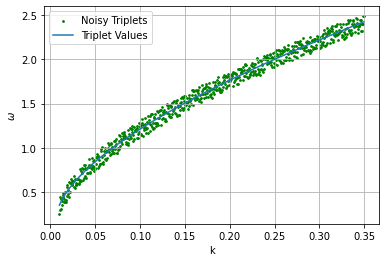

In [88]:
plt.scatter(k, noisy_w , color = 'green', label = 'Noisy Triplets', s = 3)

plt.plot(k, correct_w_trips, label = 'Triplet Values')

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

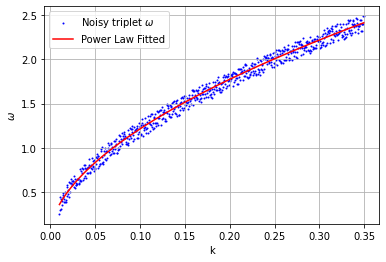

In [89]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a*x**b+c

# Fit the curve
param, covariance = curve_fit(power_law_function, k, noisy_w)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(k), max(k), 680)
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(k, noisy_w, label='Noisy triplet $\omega$ ', s=1, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [90]:
def obj(U, w_i, w_0, k):
    return (w_i/k - w_0/k - U)**2

# Initial guess for U
initial_U = np.zeros(len(k))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( y_fit, w_0, k))

# Optimized U values
optimized_U = result.x

Text(0.5, 0, 'k')

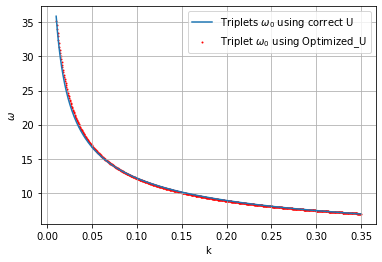

In [91]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.plot(k, w_0/k+optimized_U, label="Triplets $\omega_{0}$ using correct U ")
plt.scatter(k, w_0/k+Uk[:,0], label='Triplet $\omega_{0}$ using Optimized_U', color = 'red', s = 1)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

Text(0.5, 0, 'k')

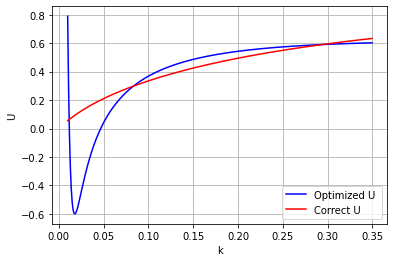

In [92]:
plt.plot(k, optimized_U, label='Optimized U ', color='blue')
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

#plt.xlim(0.1, 0.35)
#plt.ylim(0,1)

# Trying a less dense set

In [93]:
indices1 = np.array([ 16,  31,  50,  70,  93, 119, 147, 176, 208, 242, 278, 315, 354, 395, 437])

In [94]:
correct_k = k[indices1]
correct_w = correct_w_trips[indices1]
# correct values of the triplets

In [95]:
kx_0 = correct_k
ky_0 = correct_k
# DWL = deep water limit

w_0 = np.sqrt( 9.81 * np.sqrt( (kx_0)**2  + (ky_0)**2 ) )
# DWL formula

In [96]:
new_correct_w_trips = w_0 + k[indices1]*velocity[indices1]

In [97]:
# add noise 
noise_level = 0.001
noisy_w = new_correct_w_trips + np.random.uniform(-noise_level, noise_level, len(new_correct_w_trips))

Text(0.5, 0, 'k')

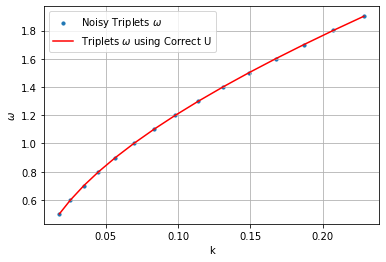

In [98]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.scatter(correct_k, noisy_w, s = 10, label="Noisy Triplets $\omega$")
plt.plot(correct_k, w_0+correct_k*Uk[:,0][indices1], label='Triplets $\omega$ using Correct U', color = 'red')

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

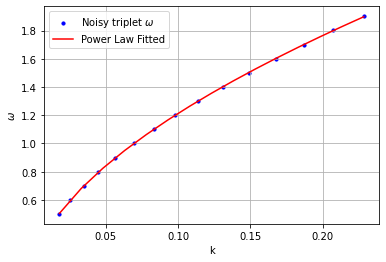

In [99]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a * x**b + c

# Fit the curve
param, covariance = curve_fit(power_law_function, correct_k, noisy_w)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(correct_k), max(correct_k), len(correct_k))
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(correct_k, noisy_w, label='Noisy triplet $\omega$ ', s=10, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [100]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.zeros(len(correct_k))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( y_fit, w_0, correct_k))

# Optimized U values
optimized_U = result.x

Text(0.5, 0, 'k')

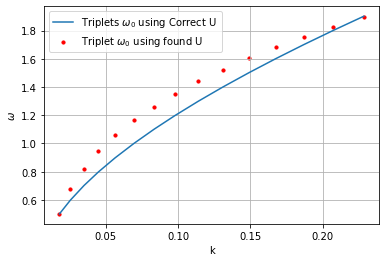

In [101]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.plot(correct_k, w_0+correct_k*Uk[:,0][indices1], label="Triplets $\omega_{0}$ using Correct U ")
plt.scatter(correct_k, w_0+correct_k*optimized_U, label='Triplet $\omega_{0}$ using found U', color = 'red', s = 10)

#plt.plot(correct_k, y_fit, color = 'black')

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

Text(0.5, 0, 'k')

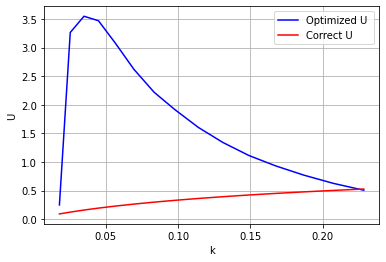

In [102]:
plt.plot(correct_k, optimized_U, label='Optimized U ', color='blue')
plt.plot(correct_k, Uk[:,0][indices1], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

#plt.xlim(0, 0.35)
#plt.ylim(0,1)